In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import metrics

2023-10-26 11:30:36.698128: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-26 11:30:36.719640: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-26 11:30:36.719661: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-26 11:30:36.719677: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-26 11:30:36.723976: I tensorflow/core/platform/cpu_feature_g

In [2]:
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2.14.0
Num GPUs Available:  1


## Load Data from Text File and Reshape

In [3]:
ttbar_dataset = np.loadtxt("out_ttbar.txt")

jets_per_event = 100
#max_events = 463
#ttbar_dataset = np.loadtxt("out_ttbar.txt", max_rows=max_events*jets_per_event)

ttbar_len = ttbar_dataset.shape[0]
ttbar_feat = ttbar_dataset.shape[1]

ttbar_events = int(ttbar_len / jets_per_event)

ttbar_dataset = ttbar_dataset.reshape((ttbar_events,jets_per_event,ttbar_feat))
print(ttbar_dataset.shape)
#print(ttbar_dataset)

(463, 100, 4)


## Calculate Edges Based on Truth Information

*Generating Edges on Truth Information is NOT good practice and should be replaced with a physics inspired algorithm with possible attention mechanism later on. Using truth information is to show proof of concept only!*

In [4]:
# Create an edges array (sparse adjacency matrix) of shape [2, num_edges].
edges = arr = np.empty((0,2), int)
labels = np.zeros((ttbar_events,jets_per_event))

for event_idx in range(ttbar_events):
    if (event_idx%1) == 0: 
        print(event_idx+1, " / ", ttbar_events, end="\r")
    for jet1_idx in range(jets_per_event):
        
        # Define proper binary classification labels
        # Truth label of -1 corresponds to hard scattering vertex
        # Truth lavel of anything else corresponds to pileup vertex
        if ttbar_dataset[event_idx,jet1_idx,-1] == -1:
            labels[event_idx,jet1_idx] = 1
        
        for jet2_idx in range(jet1_idx+1, jets_per_event):           
            # ttbar_dataset[i,j,-1] corresponds to truth label
            if ((ttbar_dataset[event_idx,jet1_idx,-1] == ttbar_dataset[event_idx,jet2_idx,-1]) and (ttbar_dataset[event_idx,jet1_idx,-1] != 0)):
                jet1_unique_ID = event_idx*jets_per_event + jet1_idx
                jet2_unique_ID = event_idx*jets_per_event + jet2_idx
                edges = np.vstack((edges, [jet1_unique_ID, jet2_unique_ID]))    
                edges = np.vstack((edges, [jet2_unique_ID, jet1_unique_ID]))
                
# Examine output
#print(labels[0])
#print(labels.shape)
#print(edges[0:5])
#print(edges.shape)

## Split Dataset into Test and Train

*The only information passed to the GNN Model is the unique index of the jet. This makes splitting test and train dataset easy.*

In [5]:
split = 0.8

idx = np.arange(ttbar_len)

split_idx = int(ttbar_len * split)

train_n = int(ttbar_len * split)
labels = labels.flatten()

print(np.mean(labels))

#x_train = idx[0:train_n]
#y_train = labels[:train_n]

x_train = idx[0:train_n]
y_train = labels[0:train_n]
x_test = idx[train_n:-1]
y_test = labels[train_n:-1]

0.09008639308855292


## Constuct Graph Info 

*Node Features, Edges, and Edge Weights*

In [6]:
#Construct graph info

# Create an edges array (sparse adjacency matrix) of shape [2, num_edges].
edges = edges.T

# Create an edge weights array of ones.
edge_weights = tf.ones(shape=edges.shape[1])

# Create a node features array of shape [num_nodes, num_features].
node_features = ttbar_dataset.reshape(ttbar_len, ttbar_feat)
node_features = tf.cast(node_features[:,0:3], dtype=tf.dtypes.float32)

#node_features_train = node_features[0:train_n,:]
#node_features_train = tf.cast(node_features_train[:,0:3], dtype=tf.dtypes.float32)

#node_features_test = node_features[train_n:-1,:]
#node_features_test = tf.cast(node_features_test[:,0:3], dtype=tf.dtypes.float32)

# Create graph info tuple with node_features, edges, and edge_weights.
graph_info = (node_features, edges, edge_weights)
#graph_info_train = (node_features_train, edges, edge_weights)
#graph_info_test = (node_features_test, edges, edge_weights)

print("Edges shape:", edges.shape)
print("Nodes shape:", node_features.shape)

Edges shape: (2, 50382)
Nodes shape: (46300, 3)


2023-10-26 11:30:39.029736: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22396 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6


## Create Simple, Configurable Feed Forward Network

*The FFN will be used for pre-processing and post-processing layers. It will also be used to perform permutation invariant message passing during the Graph Convolution Layer.*

In [7]:
def create_ffn(hidden_units, dropout_rate, name=None):
    fnn_layers = []

    for units in hidden_units:
        fnn_layers.append(layers.BatchNormalization())
        fnn_layers.append(layers.Dropout(dropout_rate))
        fnn_layers.append(layers.Dense(units, activation=tf.nn.gelu))

    return keras.Sequential(fnn_layers, name=name)

## Create Graph Convolution Layer

*Graph Convolution Layers follow from the premise of deep sets: https://arxiv.org/abs/1703.06114. The following theorem states how to construct a valid set function using two transformations: $\phi$ and $\rho$. Since MLP are considered universal function approximators, $\phi$ and $\rho$ can be modeled as neural networks.*

> **Theorem 2** A function f (X) operating on a set X having elements from a countable universe, is a
valid set function, i.e., invariant to the permutation of instances in X, iff it can be decomposed in the
form ρ (∑
x∈X φ(x)), for suitable transformations φ and ρ.

*Message passing in graph neural networks is performed using the valid set funcion shown below. The node representation in the k-1 graph layer, $x_i^{(k-1)}$, will be aggregated with neighboring nodes, $x_j^{(k-1)}$, along with (optional) edge features $e_{j,i}$ using MLP $\phi^{(k)}$. Now, $\forall j \in \mathcal{N}(i)$ we perform a permutation invariant operation (sum, mean, max) on the outputs of $\phi^{(k)}$. Then the MLP $\rho^{(k)}$ will use the result of the permutation invariant vector along with the node representation, $x_i^{(k-1)}$, to compute the updated node embedding in the k graph layer, $x_i^{(k)}$.*

$$\mathbf{x}_i^{(k)} = \rho^{(k)} \left( \mathbf{x}_i^{(k-1)}, \bigoplus_{j \in \mathcal{N}(i)} \, \phi^{(k)}\left(\mathbf{x}_i^{(k-1)}, \mathbf{x}_j^{(k-1)},\mathbf{e}_{j,i}\right) \right),$$

In [8]:
# Graph convolution layer
# source: https://keras.io/examples/graph/gnn_citations/
class GraphConvLayer(layers.Layer):
    def __init__(
        self,
        hidden_units,
        dropout_rate=0.2,
        aggregation_type="mean",
        combination_type="concat",
        normalize=False,
        *args,
        **kwargs,
    ):
        super().__init__(*args, **kwargs)

        self.aggregation_type = aggregation_type
        self.combination_type = combination_type
        self.normalize = normalize

        self.ffn_prepare = create_ffn(hidden_units, dropout_rate)
        if self.combination_type == "gated":
            self.update_fn = layers.GRU(
                units=hidden_units,
                activation="tanh",
                recurrent_activation="sigmoid",
                dropout=dropout_rate,
                return_state=True,
                recurrent_dropout=dropout_rate,
            )
        else:
            self.update_fn = create_ffn(hidden_units, dropout_rate)

    def prepare(self, node_repesentations, weights=None):
        # node_repesentations shape is [num_edges, embedding_dim].
        messages = self.ffn_prepare(node_repesentations)
        if weights is not None:
            messages = messages * tf.expand_dims(weights, -1)
        return messages

    def aggregate(self, node_indices, neighbour_messages, node_repesentations):
        # node_indices shape is [num_edges].
        # neighbour_messages shape: [num_edges, representation_dim].
        # node_repesentations shape is [num_nodes, representation_dim]
        num_nodes = node_repesentations.shape[0]
        if self.aggregation_type == "sum":
            aggregated_message = tf.math.unsorted_segment_sum(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "mean":
            aggregated_message = tf.math.unsorted_segment_mean(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "max":
            aggregated_message = tf.math.unsorted_segment_max(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        else:
            raise ValueError(f"Invalid aggregation type: {self.aggregation_type}.")

        return aggregated_message

    def update(self, node_repesentations, aggregated_messages):
        # node_repesentations shape is [num_nodes, representation_dim].
        # aggregated_messages shape is [num_nodes, representation_dim].
        if self.combination_type == "gru":
            # Create a sequence of two elements for the GRU layer.
            h = tf.stack([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "concat":
            # Concatenate the node_repesentations and aggregated_messages.
            h = tf.concat([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "add":
            # Add node_repesentations and aggregated_messages.
            h = node_repesentations + aggregated_messages
        else:
            raise ValueError(f"Invalid combination type: {self.combination_type}.")

        # Apply the processing function.
        node_embeddings = self.update_fn(h)
        if self.combination_type == "gru":
            node_embeddings = tf.unstack(node_embeddings, axis=1)[-1]

        if self.normalize:
            node_embeddings = tf.nn.l2_normalize(node_embeddings, axis=-1)
        return node_embeddings

    def call(self, inputs):
        """Process the inputs to produce the node_embeddings.

        inputs: a tuple of three elements: node_repesentations, edges, edge_weights.
        Returns: node_embeddings of shape [num_nodes, representation_dim].
        """

        node_repesentations, edges, edge_weights = inputs
        # Get node_indices (source) and neighbour_indices (target) from edges.
        node_indices, neighbour_indices = edges[0], edges[1]
        # neighbour_repesentations shape is [num_edges, representation_dim].
        neighbour_repesentations = tf.gather(node_repesentations, neighbour_indices)

        # Prepare the messages of the neighbours.
        neighbour_messages = self.prepare(neighbour_repesentations, edge_weights)
        # Aggregate the neighbour messages.
        aggregated_messages = self.aggregate(
            node_indices, neighbour_messages, node_repesentations
        )
        # Update the node embedding with the neighbour messages.
        return self.update(node_repesentations, aggregated_messages)


## Construct GNN Node Classifier

*This is the 'driver' function that links together pre-processing, graph convolution layer, post-processing layer, and the final classification layer.*

In [9]:
# Defines the model structure and performs classification on nodes
# source: https://keras.io/examples/graph/gnn_citations/
class GNNNodeClassifier(tf.keras.Model):
    def __init__(
        self,
        graph_info,
        num_classes,
        hidden_units,
        aggregation_type="sum",
        combination_type="concat",
        dropout_rate=0.2,
        normalize=True,
        *args,
        **kwargs,
    ):
        super().__init__(*args, **kwargs)

        # Unpack graph_info to three elements: node_features, edges, and edge_weight.
        node_features, edges, edge_weights = graph_info
        self.node_features = node_features
        self.edges = edges
        self.edge_weights = edge_weights
        # Set edge_weights to ones if not provided.
        if self.edge_weights is None:
            self.edge_weights = tf.ones(shape=edges.shape[1])
        # Scale edge_weights to sum to 1.
        self.edge_weights = self.edge_weights / tf.math.reduce_sum(self.edge_weights)

        # Create a process layer.
        self.preprocess = create_ffn(hidden_units, dropout_rate, name="preprocess")
        # Create the first GraphConv layer.
        self.conv1 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv1",
        )
        # Create the second GraphConv layer.
        #self.conv2 = GraphConvLayer(
        #    hidden_units,
        #    dropout_rate,
        #    aggregation_type,
        #    combination_type,
        #    normalize,
        #    name="graph_conv2",
        #)
        # Create a postprocess layer.
        self.postprocess = create_ffn(hidden_units, dropout_rate, name="postprocess")
        # Create a compute logits layer.
        self.compute_logits = layers.Dense(units=num_classes, name="logits", activation="sigmoid")

    def call(self, input_node_indices):
        # Preprocess the node_features to produce node representations.
        x = self.preprocess(self.node_features)
        # Apply the first graph conv layer.
        x1 = self.conv1((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x1 + x
        # Apply the second graph conv layer.
        #x2 = self.conv2((x, self.edges, self.edge_weights))
        # Skip connection.
        #x = x2 + x
        # Postprocess node embedding.
        x = self.postprocess(x)
        # Fetch node embeddings for the input node_indices.
        node_embeddings = tf.gather(x, input_node_indices)
        # Compute logits
        return self.compute_logits(node_embeddings)


## Initialize the GNN Model

*Define model parameters, initialize GNNNodeClassifier object, and test the model by passing a list of node indicies, [1, 10, 100], to get the output score of the model. Notice the model is untrained, so these values are insignificant.*

In [10]:
hidden_units = [16, 32, 32, 16]
learning_rate = 0.001
dropout_rate = 0.25
num_epochs = 100
batch_size = 256
num_classes = 1     # Binary Classification [0,1]

gnn_model = GNNNodeClassifier(
    graph_info=graph_info,
    num_classes=num_classes,
    hidden_units=hidden_units,
    dropout_rate=dropout_rate,
    name="gnn_model",
)

print("GNN output shape:", gnn_model([1, 10, 100]))

gnn_model.summary()


GNN output shape: tf.Tensor(
[[0.64327484]
 [0.5240743 ]
 [0.7798216 ]], shape=(3, 1), dtype=float32)
Model: "gnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 preprocess (Sequential)     (46300, 16)               2524      
                                                                 
 graph_conv1 (GraphConvLaye  multiple                  5888      
 r)                                                              
                                                                 
 postprocess (Sequential)    (46300, 16)               2784      
                                                                 
 logits (Dense)              multiple                  17        
                                                                 
Total params: 11213 (43.80 KB)
Trainable params: 10439 (40.78 KB)
Non-trainable params: 774 (3.02 KB)
___________________________________________________

## Define the Training Loop

*Compile the model with the optimizer, loss function, and training metric. Implement early stoppting to prevent overtraining. Finally, train the model using model.fit().*

In [11]:
def run_experiment(model, x_train, y_train):
    # Compile the model.
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.BinaryCrossentropy(from_logits=False),
        metrics=[keras.metrics.BinaryAccuracy(name="acc")],
    )
    # Create an early stopping callback.
    early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_acc", patience=10, restore_best_weights=True
    )
    # Fit the model.
    history = model.fit(
        x=x_train,
        y=y_train,
        epochs=num_epochs,
        batch_size=batch_size,
        validation_split=0.15,
        callbacks=[early_stopping],
        shuffle=True,
        use_multiprocessing=True,
    )

    return history

In [12]:
history = run_experiment(gnn_model, x_train, y_train)

Epoch 1/100


2023-10-26 11:30:43.529315: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f58a45f9d20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-26 11:30:43.529337: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2023-10-26 11:30:43.531825: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-26 11:30:43.539518: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-10-26 11:30:43.583322: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


123/123 [==============================] - 7s 15ms/step - loss: 0.5508 - acc: 0.7644 - val_loss: 0.2611 - val_acc: 0.9100
Epoch 2/100
123/123 [==============================] - 2s 12ms/step - loss: 0.2738 - acc: 0.9014 - val_loss: 0.2144 - val_acc: 0.9100
Epoch 3/100
123/123 [==============================] - 2s 13ms/step - loss: 0.2447 - acc: 0.9050 - val_loss: 0.2125 - val_acc: 0.9100
Epoch 4/100
123/123 [==============================] - 2s 12ms/step - loss: 0.2342 - acc: 0.9068 - val_loss: 0.1963 - val_acc: 0.9100
Epoch 5/100
123/123 [==============================] - 2s 12ms/step - loss: 0.2264 - acc: 0.9076 - val_loss: 0.1957 - val_acc: 0.9100
Epoch 6/100
123/123 [==============================] - 2s 13ms/step - loss: 0.2185 - acc: 0.9097 - val_loss: 0.1907 - val_acc: 0.9100
Epoch 7/100
123/123 [==============================] - 2s 12ms/step - loss: 0.2130 - acc: 0.9115 - val_loss: 0.1870 - val_acc: 0.9111
Epoch 8/100
123/123 [==============================] - 2s 13ms/step - loss

## Display Learning Curves

In [13]:
def display_learning_curves(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history.history["loss"])
    ax1.plot(history.history["val_loss"])
    ax1.legend(["train", "validation"], loc="upper right")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")

    ax2.plot(history.history["acc"])
    ax2.plot(history.history["val_acc"])
    ax2.legend(["train", "validation"], loc="upper right")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    plt.show()


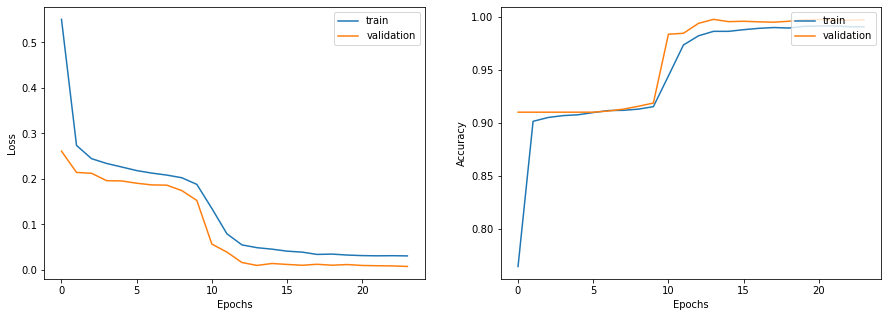

In [14]:
display_learning_curves(history)

## Calulate ROC Curves, AUC and F1 score

*ROC Curves show TPR vs FPS. AUC is the area under the ROC curve (higher is better). $F1 = \frac{2 * precision * recall}{precision + recall} = \frac{2*tpr}{2*tpr+fpr*fnr}$ (higher is better). To calculate ROC Curves, x_test is used, which a fraction of the dataset that the model has not seen before.*

In [15]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import f1_score

y_pred = gnn_model.predict(x_test).ravel()
y_true = y_test

290/290 [==============================] - 1s 2ms/step


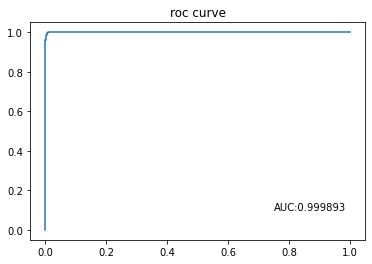

In [16]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_true, y_pred)
AUC = auc(fpr_keras, tpr_keras)
plt.plot(fpr_keras, tpr_keras)
plt.title("roc curve")
plt.text(0.75,0.1,"AUC:"+str(round(AUC,6)))
plt.show()

In [17]:
threshhold = 0.5

y_pred_threshold = np.copy(y_pred)
y_pred_threshold[y_pred_threshold >= threshhold] = 1
y_pred_threshold[y_pred_threshold < threshhold] = 0

#print(y_pred_threshold[0:100])
#print(np.mean(y_pred_threshold))

F1 = f1_score(y_true, y_pred_threshold)
print("F1 Score: ", F1)

F1 Score:  0.9850357839947951


In [18]:
%load_ext tensorboard
import tensorboard
tensorboard.__version__

'2.14.1'

In [19]:
%tensorboard

ERROR: Could not find `tensorboard`. Please ensure that your PATH
contains an executable `tensorboard` program, or explicitly specify
the path to a TensorBoard binary by setting the `TENSORBOARD_BINARY`
environment variable.